In [43]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)
import xcdat as xc

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/work/aswann/conda-envs/xcdat_plus/lib/python3.11/site-packages/xarray/core/options.py:121: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM

MPI-ESM1-2-LR also did the experiments but I don't see any ouptut on NIRD

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr by year YYY, continues at zero emissions until 200 years past flat10

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella)
I tried to find matching grid files but none of the GISS models from CMIP6 appear to have the same resolution as the data from flat10

In [246]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist= ['ACCESS-ESM1-5',  
            'CESM2',  
            'CNRM-ESM2-1',  
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

modelcolors=['dodgerblue','mediumvioletred','red','olive','cyan','gray']


varlist=['fgco2','hfds','tas']#,'spco2',]
unitslist=['kgC m-2 s-1', 'W m-2','K']

# there seems to be a problem with ra for NorESM

In [247]:
# initialize a dictionary to hold all of the data
data_dict={}

In [248]:
# define constants

speryr=60*60*24*365

# unit conversion for fgco2 to PgC/yr
# kgC/m2/s * speryr * 1e3 g/kg * 1e-15 Pg/g





### Define Functions

In [249]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [250]:
def select_time_slice(dataset, startyear, endyear):
    """
    Selects the years between start year and end year
    of data from an xarray dataset.
    start year references 0 as the first year
    
    Args:
    - dataset: xarray dataset containing the time dimension
    
    Returns:
    - time_slice: xarray dataset containing the years of data between startyear and endyear

    Example usage:
    Assuming you have a list of xarray datasets called 'datasets'
    first_10_years_datasets = [select_first_10_years(dataset,startyear,endyear) for dataset in datasets]
    alternatively just retrieve a time slice for one dataset at a time
    """
    
    # Check if the dataset has a dimension labeled "time"
    if 'time' not in dataset.dims:
        # if the model is GISS, then it does not have a cftime time index 
        # and instead just an index of years
        time_coord = dataset.year.values
        time_slice = dataset.sel(year=slice(time_coord[0] + startyear, time_coord[0] + endyear))

    else:
        # model uses cftime
        # Extract the time coordinate from the dataset
        time_coord = dataset.time.values
        
        # Determine the calendar type of the dataset
        calendar_type = time_coord[0].calendar
        
        # Calculate the end date for the first 10 years based on the calendar type
        if calendar_type in ['standard', 'gregorian', 'proleptic_gregorian']:
            start_date = cftime.DatetimeGregorian(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeGregorian(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == 'noleap':
            start_date = cftime.DatetimeNoLeap(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeNoLeap(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == '365_day':
            start_date = cftime.Datetime360Day(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.Datetime360Day(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        # Add more conditions for other calendar types if needed
        
        # Select the time slice
        time_slice = dataset.sel(time=slice(start_date, end_date))
    
    return time_slice


### Load grid info

In [251]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # get area of ocean gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
        areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
        if model =='CESM2':
            areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

        # add to the dictionary
        data_dict[model +'_areacella'] = areacella
        data_dict[model +'_areacello'] = areacello


ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
CNRM-ESM2-1 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 does not have grid info
NorESM2-LM getting grid info


### Load data

In [252]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
            if 'nep' in dsmerge_f:
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep')
                
            # check units and convert if necessary - at the moment this is just CESM for carbon variables
            #if ds[veg].units != unitslist[v]:
                # the unit does not match what we expect, 
                # convert the unit and update the metadata
            # At the moment this only applies to CESM, but should catch the CESM units and not others
            # flux variables
            # test first to see if the variable exists. nbp is missnamed in one model
            if var in dsmerge_f: 
                if dsmerge_f[var].units == 'gC/m^2/s':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                # stock variables
                elif dsmerge_f[var].units == 'gC/m^2':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2'
                elif dsmerge_f[var].units == 'mmol/m^3 cm/s':
                    dsmerge_f[var]=dsmerge_f[var]* 1e-8* 12 # convert from mmol/m^3 cm/s to kgC/m2/s 
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                else:
                    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray

            
            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
                
                
        
        # save output to a dictionary
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


adding ACCESS-ESM1-5 flat10 to dict
adding ACCESS-ESM1-5 flat10_zec to dict
adding ACCESS-ESM1-5 flat10_cdr to dict
adding CESM2 flat10 to dict
adding CESM2 flat10_zec to dict
adding CESM2 flat10_cdr to dict
adding CNRM-ESM2-1 flat10 to dict
adding CNRM-ESM2-1 flat10_zec to dict
adding CNRM-ESM2-1 flat10_cdr to dict
adding GFDL-ESM4 flat10 to dict
adding GFDL-ESM4 flat10_zec to dict
adding GFDL-ESM4 flat10_cdr to dict
adding GISS_E2.1 flat10 to dict
adding GISS_E2.1 flat10_zec to dict
adding GISS_E2.1 flat10_cdr to dict
adding NorESM2-LM flat10 to dict
adding NorESM2-LM flat10_zec to dict
adding NorESM2-LM flat10_cdr to dict


In [253]:
# make annual mean time series of global averages weighted by area of gridcell for each model
# doing this by hand because every model has a different name for the ocean grid dimensions

# save the ocean area, initialize an array
oceanarea=np.ones(len(modellist))

# loop over experiments
for r in range(len(runlist)):
    run=runlist[r] 

    # compute each model seperately because they all have different names for ocean grid dimensions
    #-----
    
    m=0
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    ds_area=data_dict[model +'_areacello']
    ds_areaA=data_dict[model +'_areacella']
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=ds_area.areacello.sum(dim=['i','j'])

    #-----
    
    m=1
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    ds_area=data_dict[model +'_areacello']
    ds_areaA=data_dict[model +'_areacella']
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    areaA = ds_areaA.areacella.squeeze(dim='time', drop=True)
    area_weighted_ann_mean=(areaA*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/areaA.sum(dim=['lat','lon'])
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=ds_area.areacello.sum(dim=['nlat','nlon'])

    #-----
    
    m=2
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    ds_area=data_dict[model +'_areacello']
    ds_areaA=data_dict[model +'_areacella']
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['x','y'])/ds_area.areacello.sum(dim=['x','y'])
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['x','y'])/ds_area.areacello.sum(dim=['x','y'])
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=ds_area.areacello.sum(dim=['x','y'])
    
    #-----
    
    m=3
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    ds_area=data_dict[model +'_areacello']
    ds_areaA=data_dict[model +'_areacella']
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['xh','yh'])/ds_area.areacello.sum(dim=['xh','yh'])
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['xh','yh'])/ds_area.areacello.sum(dim=['xh','yh'])
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=ds_area.areacello.sum(dim=['xh','yh'])

    
    #-----
    
    m=4 # GISS already in annual mean
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    # no grid files, use lat and lon geometry
    
    weights = np.cos(np.deg2rad(ds.lat))
    var_weighted = ds.hfds.weighted(weights)
    area_weighted_ann_mean = var_weighted.mean(("lon", "lat"))
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    var_weighted = ds.tas.weighted(weights)
    area_weighted_ann_mean = var_weighted.mean(("lon", "lat"))
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    weights = np.cos(np.deg2rad(ds.lato))
    var_weighted = ds.fgco2.weighted(weights)
    area_weighted_ann_mean = var_weighted.mean(("lono", "lato"))
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=np.nan

    
    #-----
    
    m=5
    
    model=modellist[m]
    modelkey=model +'_' +run
    ds=data_dict[modelkey]
    ds_area=data_dict[model +'_areacello']
    ds_areaA=data_dict[model +'_areacella']
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
    ts1 = area_weighted_ann_mean.to_dataset(name='hfds')
    
    area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
    ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')
    
    area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
    ts3 = area_weighted_ann_mean.to_dataset(name='tas')
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
    data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])
    oceanarea[m]=ds_area.areacello.sum(dim=['i','j'])

    #-----


adding ACCESS-ESM1-5 flat10_timeseries to dict
adding CESM2 flat10_timeseries to dict
adding CNRM-ESM2-1 flat10_timeseries to dict
adding GFDL-ESM4 flat10_timeseries to dict
adding GISS_E2.1 flat10_timeseries to dict
adding NorESM2-LM flat10_timeseries to dict
adding ACCESS-ESM1-5 flat10_zec_timeseries to dict
adding CESM2 flat10_zec_timeseries to dict
adding CNRM-ESM2-1 flat10_zec_timeseries to dict
adding GFDL-ESM4 flat10_zec_timeseries to dict
adding GISS_E2.1 flat10_zec_timeseries to dict
adding NorESM2-LM flat10_zec_timeseries to dict
adding ACCESS-ESM1-5 flat10_cdr_timeseries to dict
adding CESM2 flat10_cdr_timeseries to dict
adding CNRM-ESM2-1 flat10_cdr_timeseries to dict
adding GFDL-ESM4 flat10_cdr_timeseries to dict
adding GISS_E2.1 flat10_cdr_timeseries to dict
adding NorESM2-LM flat10_cdr_timeseries to dict


In [255]:
# save the ocean area
oceanarea=np.ones(len(modellist))

m=0

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

oceanarea[m]=ds_area.areacello.sum(dim=['i','j'])

m=1

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

oceanarea[m]=ds_area.areacello.sum(dim=['nlat','nlon'])

m=2

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

oceanarea[m]=ds_area.areacello.sum(dim=['x','y'])

m=3

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

oceanarea[m]=ds_area.areacello.sum(dim=['xh','yh'])



m=5

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

oceanarea[m]=ds_area.areacello.sum(dim=['i','j'])


# no grid for m=4
m=4
oceanarea[m]=(oceanarea[0]+oceanarea[2]+oceanarea[3]+oceanarea[4]+oceanarea[5])/5

oceanarea

array([3.61335968e+14, 5.04921015e+14, 3.64822374e+14, 5.05582008e+14,
       3.18472979e+14, 3.60624547e+14])

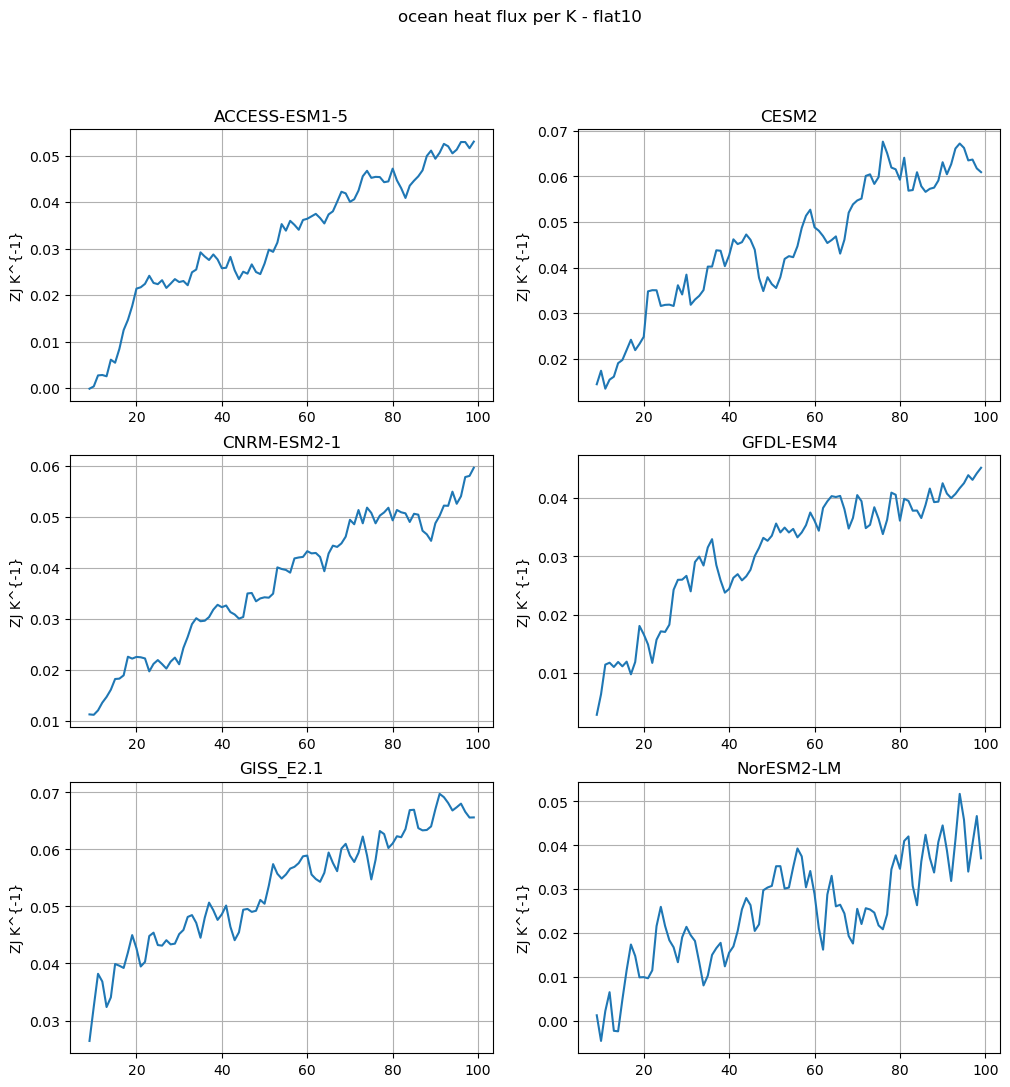

done saving file


In [256]:
run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:100]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

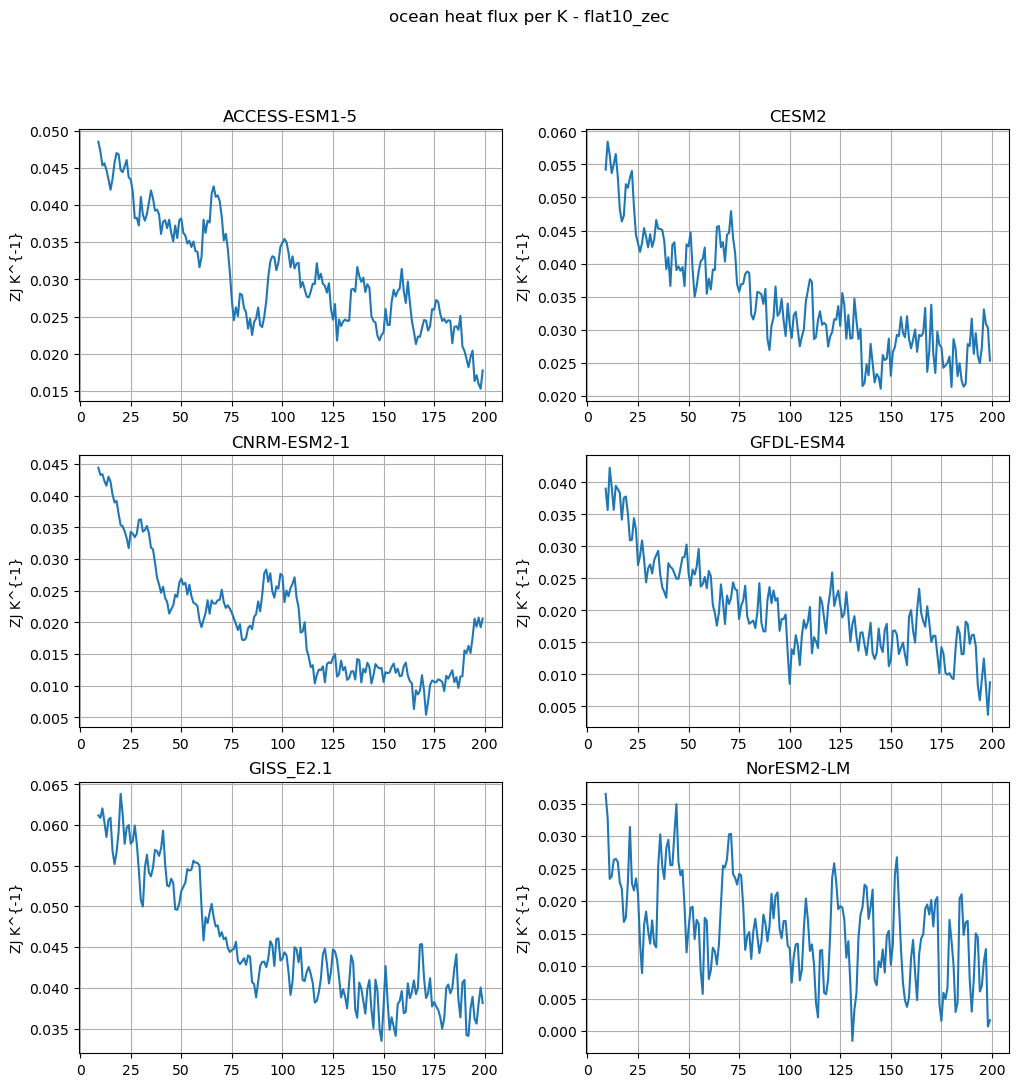

done saving file


In [257]:
run=runlist[1]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

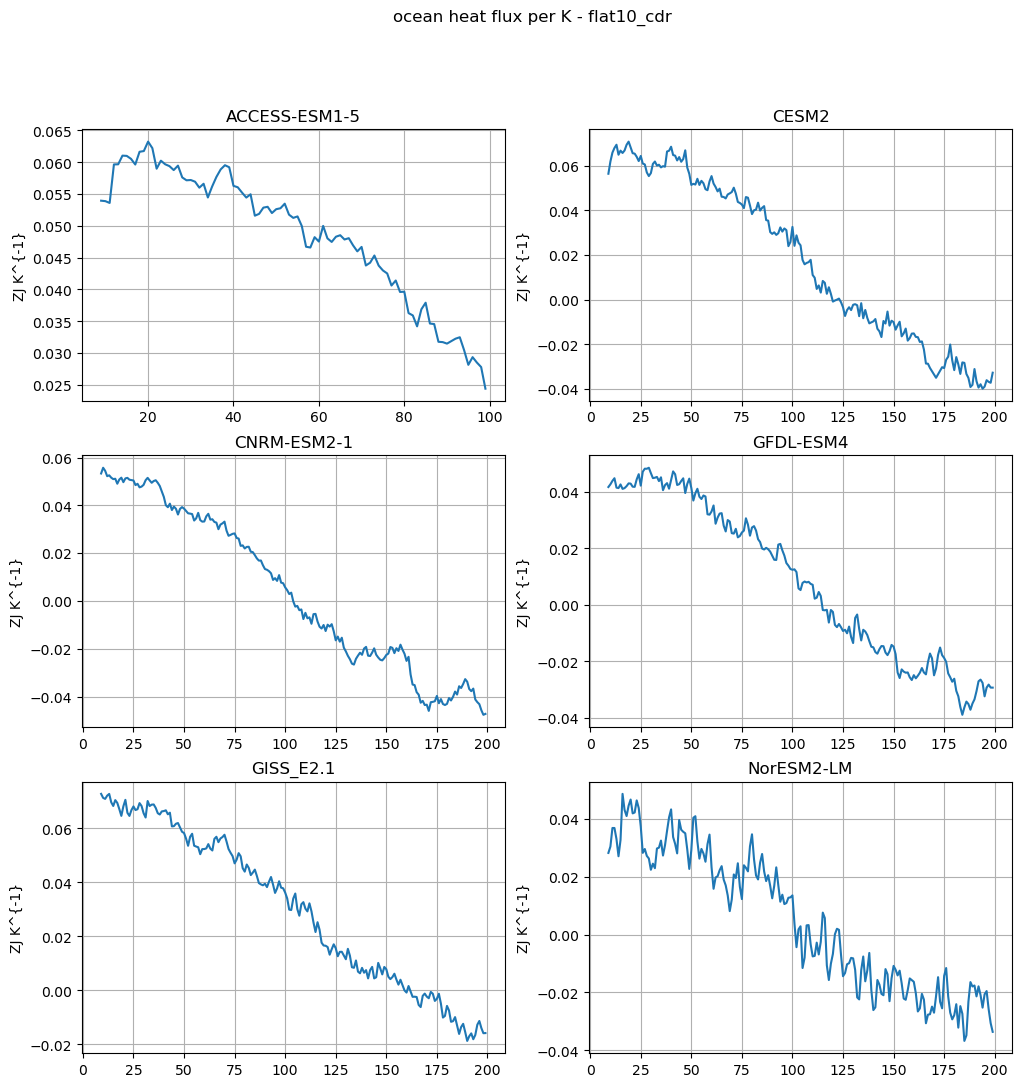

done saving file


In [259]:
run=runlist[2]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

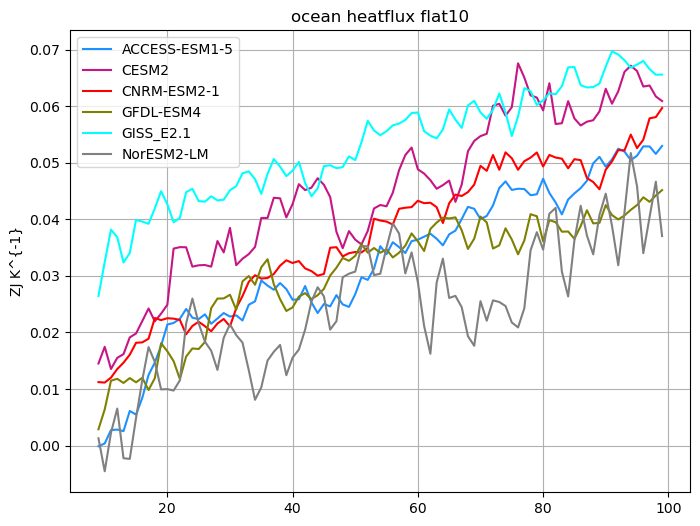

done saving file


In [261]:
run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(8,6))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:100]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])

plt.title('ocean heatflux ' +run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('ZJ K^{-1}')

plt.legend(modellist)

#fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_onepanel_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

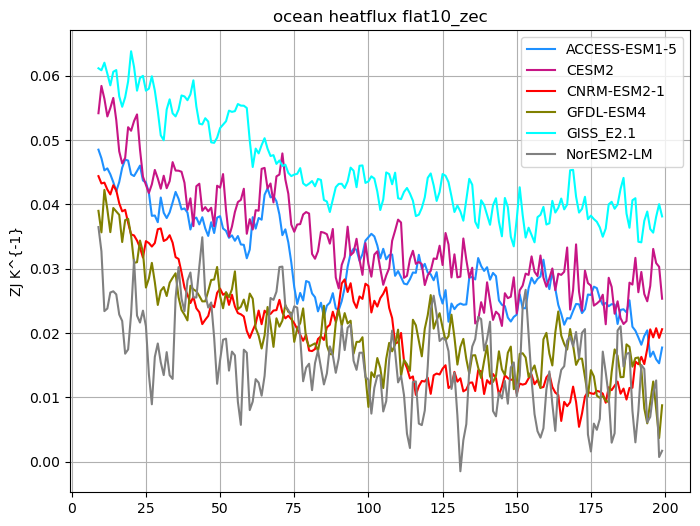

done saving file


In [262]:
run=runlist[1]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(8,6))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title('ocean heatflux ' +run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('ZJ K^{-1}')

plt.legend(modellist)

#fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_onepanel_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

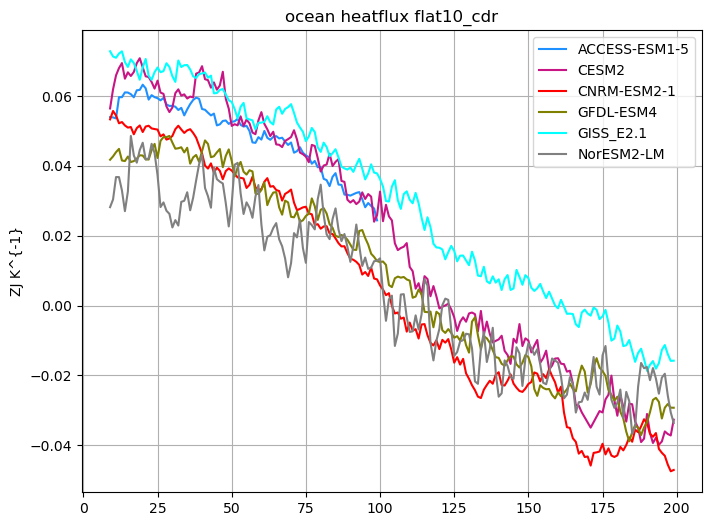

done saving file


In [263]:
run=runlist[2]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(8,6))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title('ocean heatflux ' +run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('ZJ K^{-1}')

plt.legend(modellist)

#fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_onepanel_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

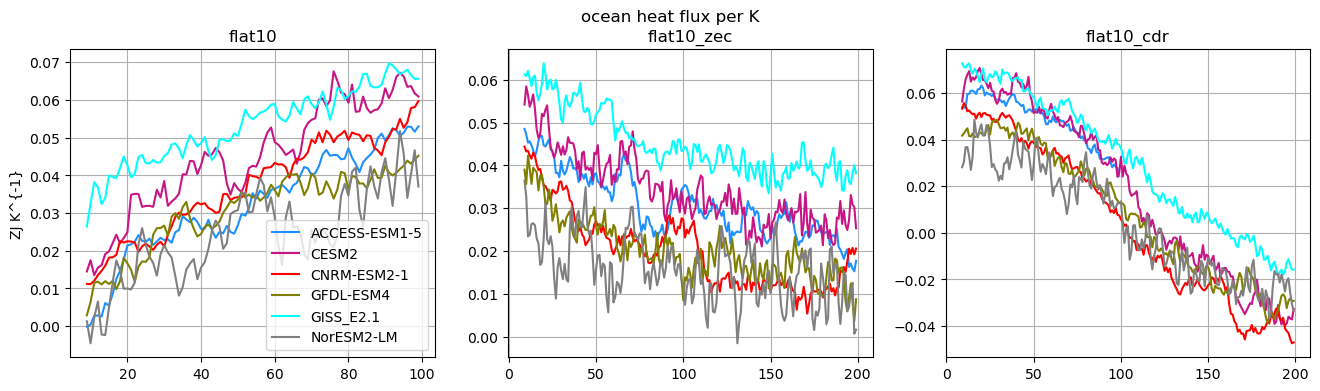

done saving file


In [267]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,4))

r=0
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:100]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])

plt.title(run)
plt.grid()

#plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('ZJ K^{-1}')

plt.legend(modellist)


r=1
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')

r=2
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux/ds.tas
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean heat flux per K')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_onepanel_allruns.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

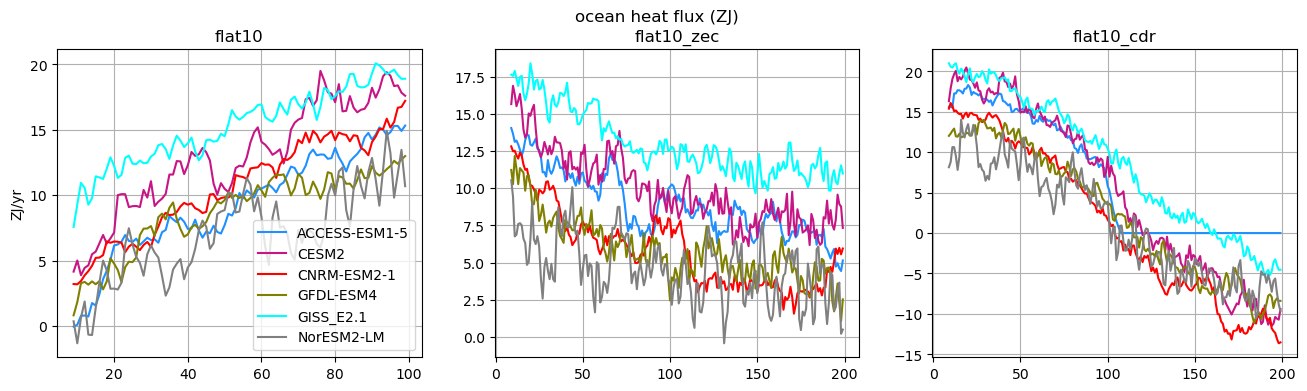

done saving file


In [276]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,4))

r=0
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:100]*speryr*1e-21*oceanarea[m]
    ts = heatflux
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])

plt.title(run)
plt.grid()

#plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('ZJ/yr')

plt.legend(modellist)


r=1
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')

r=2
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]
    ts = heatflux
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean heat flux (ZJ)')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatflux_onepanel_allruns.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

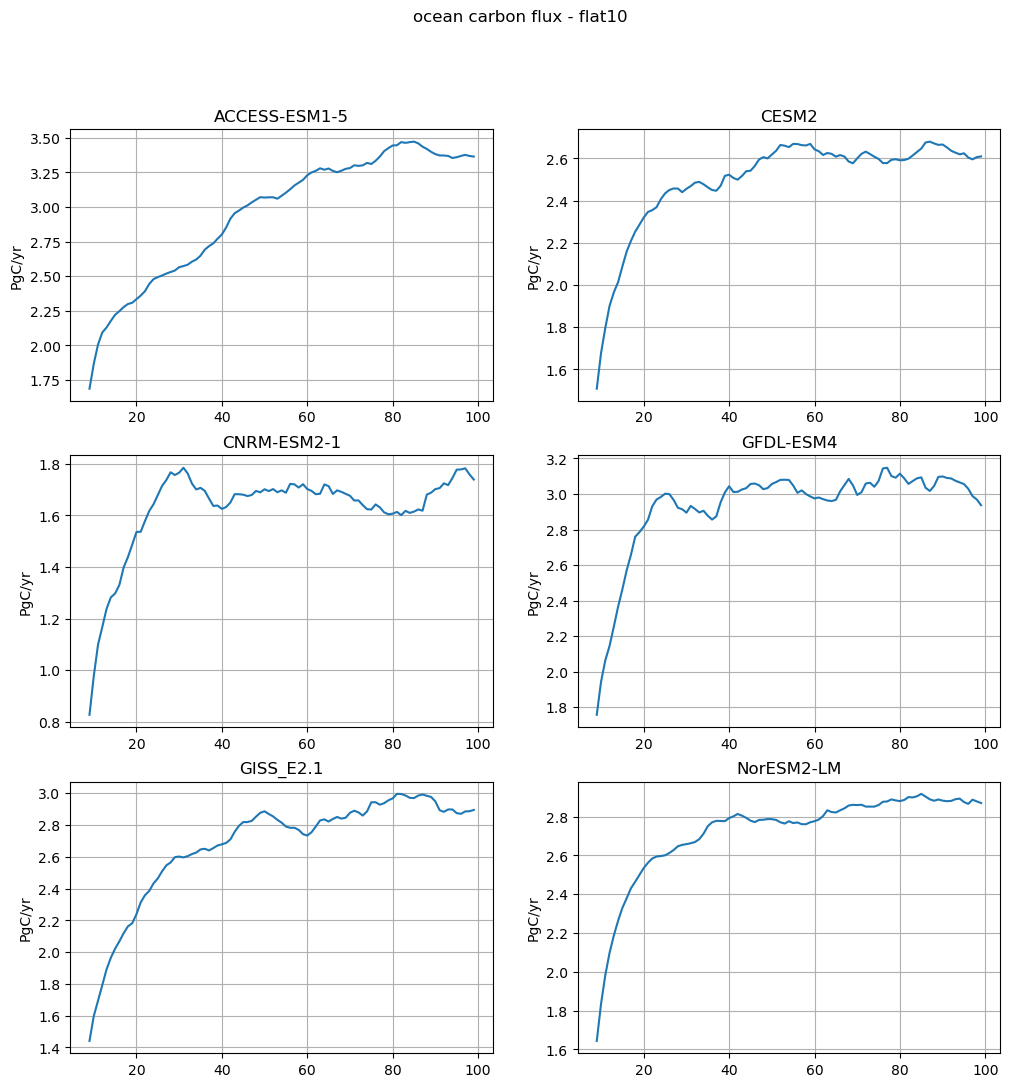

done saving file


In [269]:
run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    carbonflux = ds.fgco2[0:100]*speryr*1e-12*oceanarea[m]
    ts = carbonflux
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('PgC/yr')


fig.suptitle('ocean carbon flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceancarbonflux_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

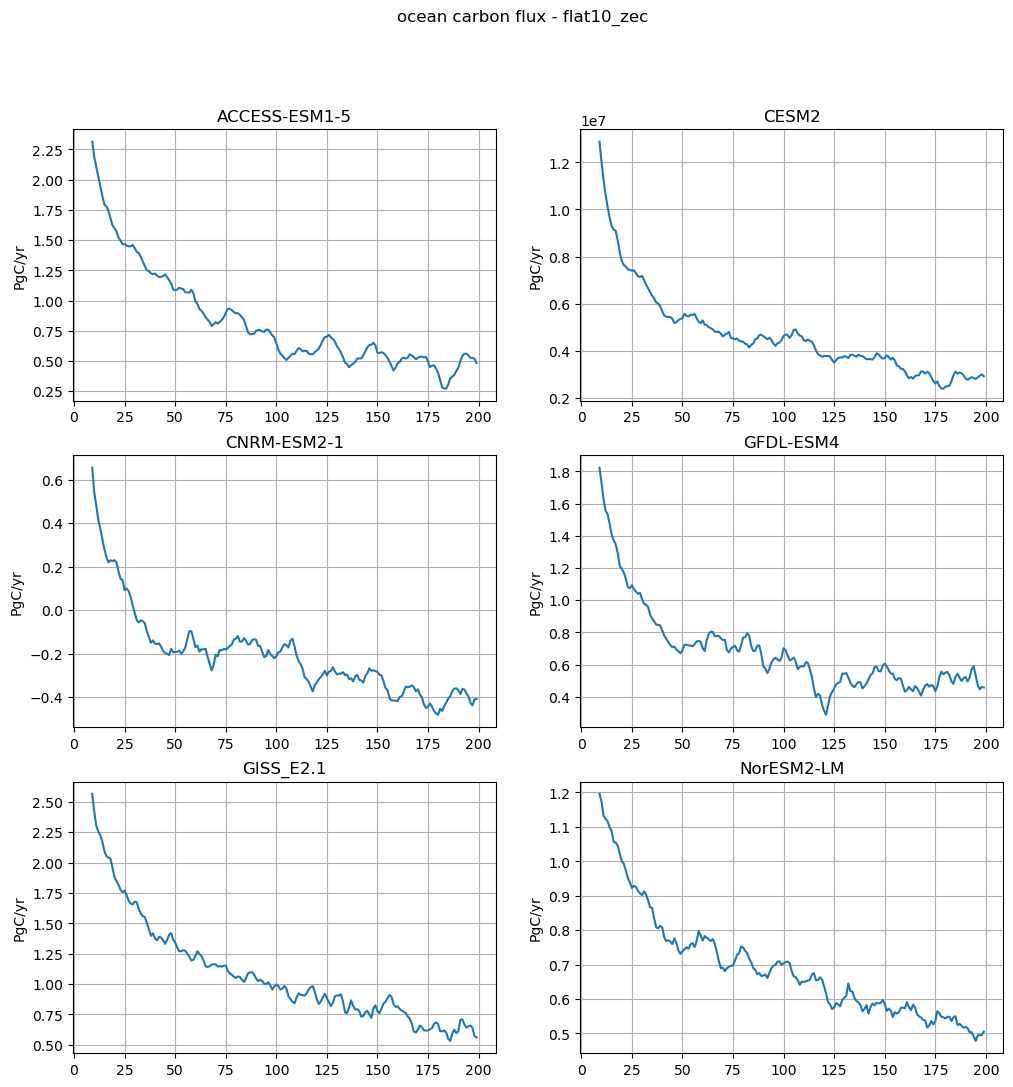

done saving file


In [232]:
run=runlist[1]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    carbonflux = ds.fgco2[0:200]*speryr*1e-12*oceanarea[m]
    ts = carbonflux
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('PgC/yr')


fig.suptitle('ocean carbon flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceancarbonflux_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

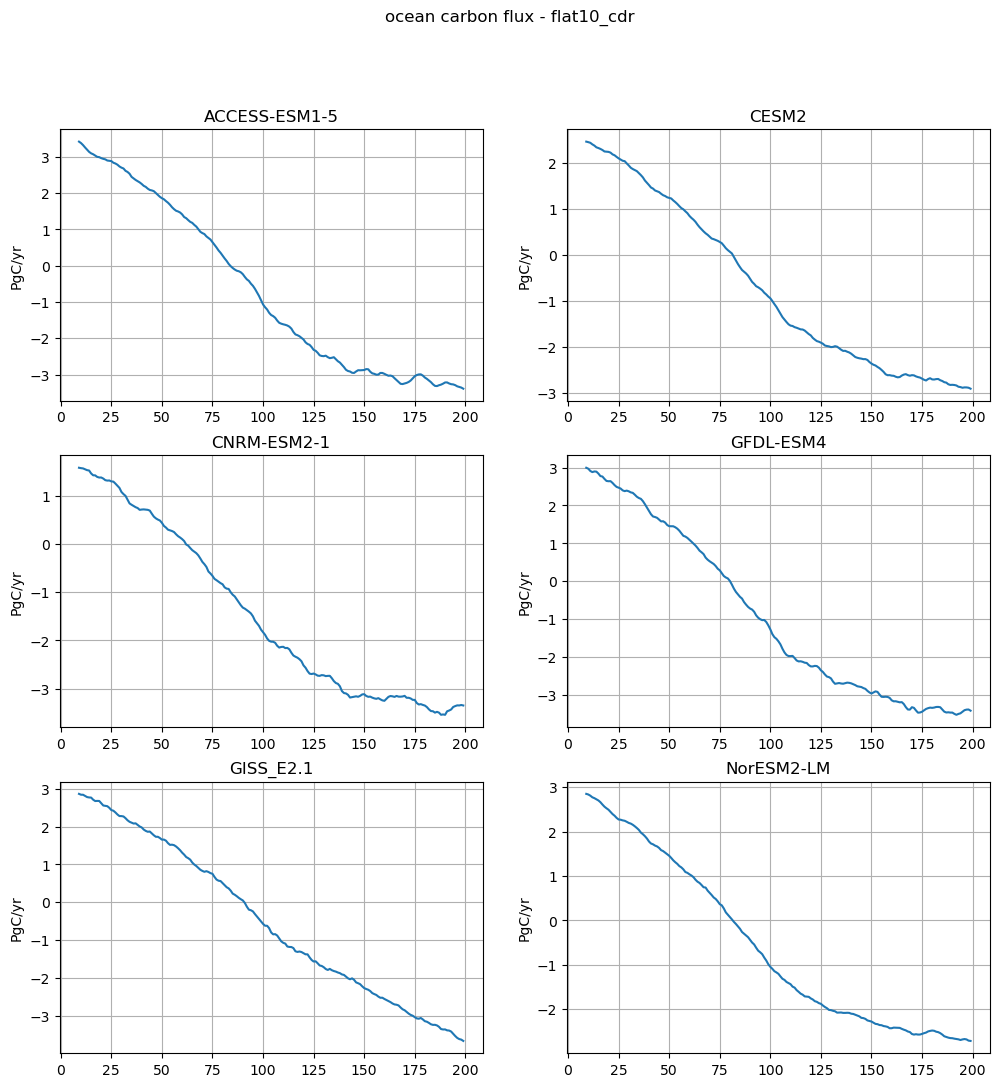

done saving file


In [270]:
run=runlist[2]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    carbonflux = ds.fgco2[0:200]*speryr*1e-12*oceanarea[m]
    ts = carbonflux
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('PgC/yr')


fig.suptitle('ocean carbon flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceancarbonflux_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

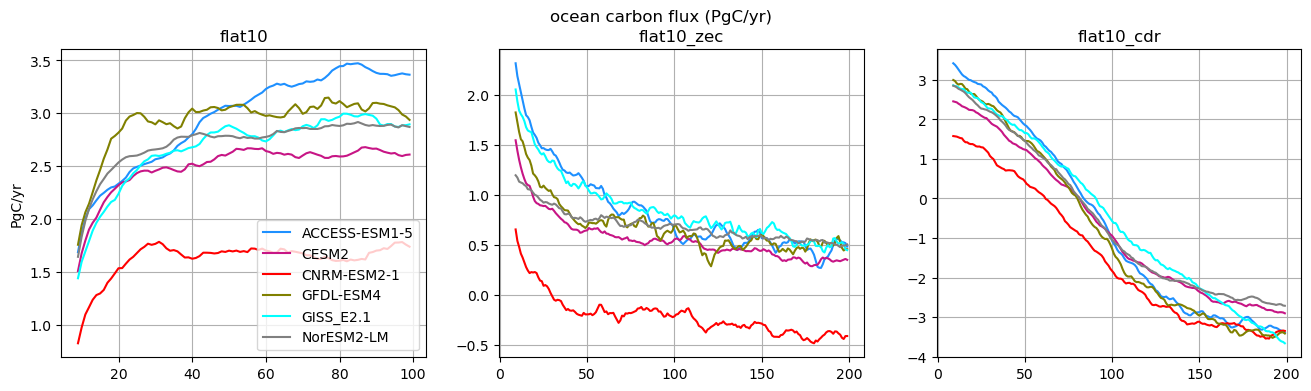

done saving file


In [275]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,4))

r=0
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    ts = (ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m])
    if model=='GISS_E2.1':
        ts2=ts[0:100].rolling(year=10).mean()
    else:
        ts2=ts[0:100].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])

plt.title(run)
plt.grid()

#plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
plt.ylabel('PgC/yr')

plt.legend(modellist)


r=1
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    ts = (ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m])
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')

r=2
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    ts = (ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m])
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()
    
    plt.plot(ts2,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
#plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean carbon flux (PgC/yr)')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceancarbonflux_onepanel_allruns.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

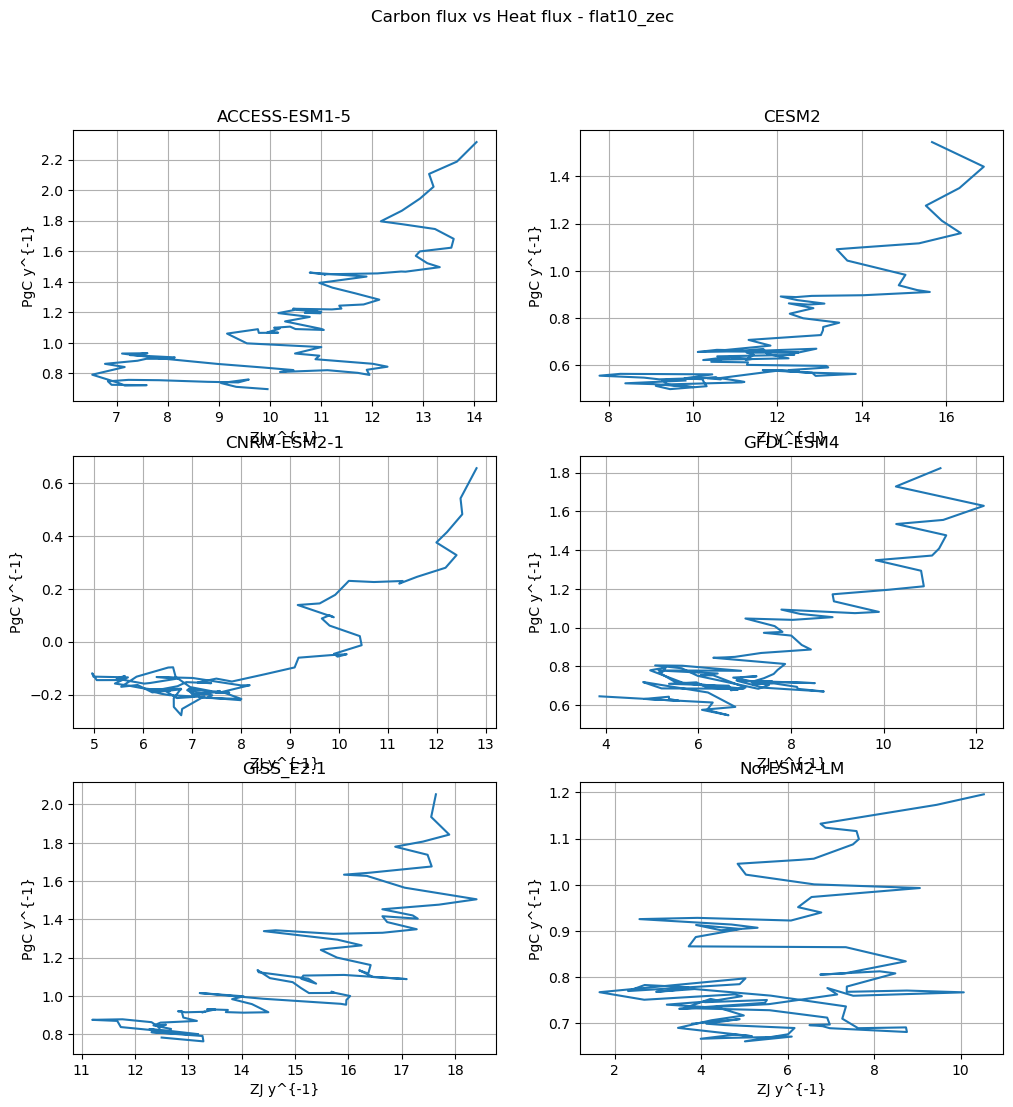

done saving file


In [277]:
run=runlist[1]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # unit conversions


    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr

    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(heatflux, carbonflux)#,'.')
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    plt.xlabel('ZJ y^{-1}')
    plt.ylabel('PgC y^{-1}')


fig.suptitle('Carbon flux vs Heat flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonVsheat_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

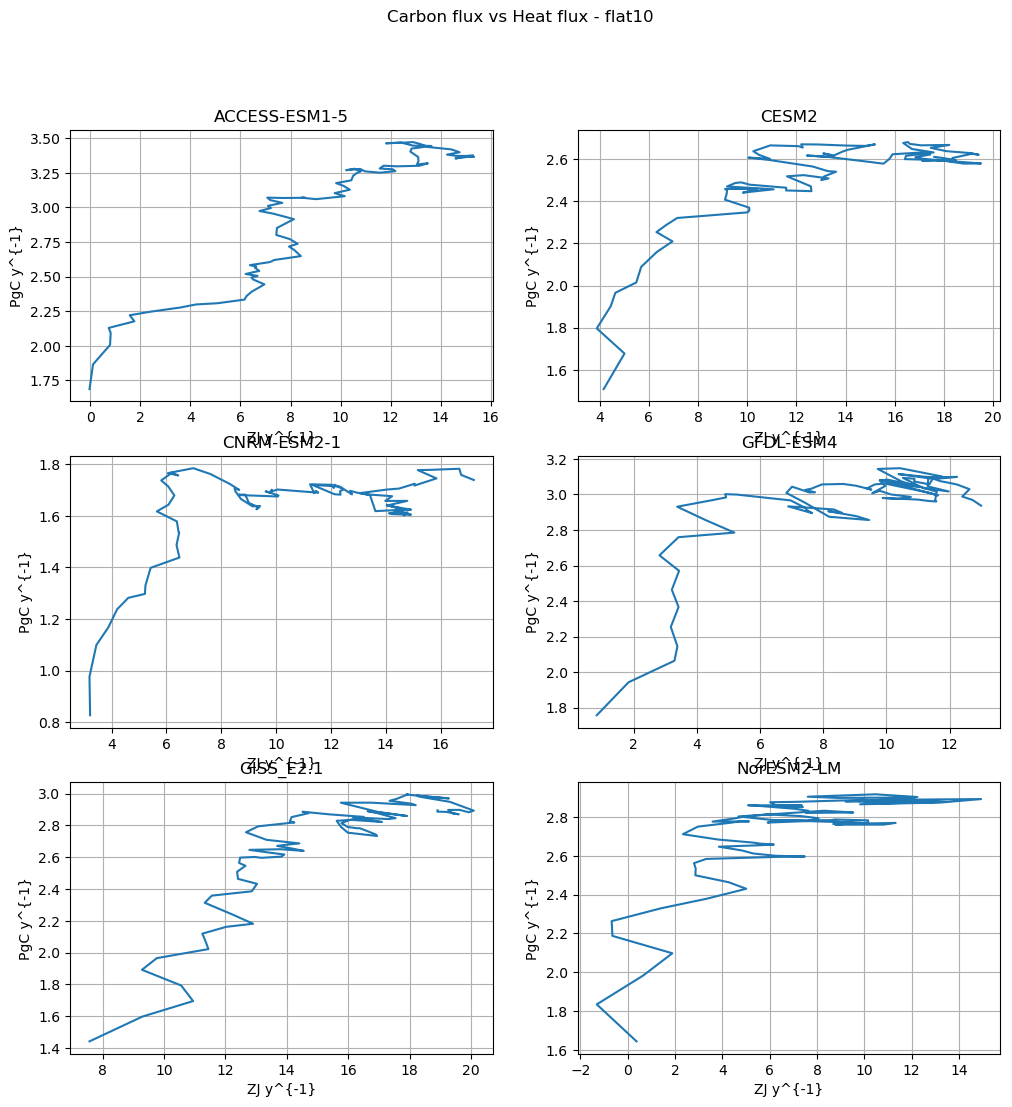

done saving file


In [278]:
run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # unit conversions


    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr

    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(heatflux, carbonflux)#,'.')
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    plt.xlabel('ZJ y^{-1}')
    plt.ylabel('PgC y^{-1}')


fig.suptitle('Carbon flux vs Heat flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonVsheat_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

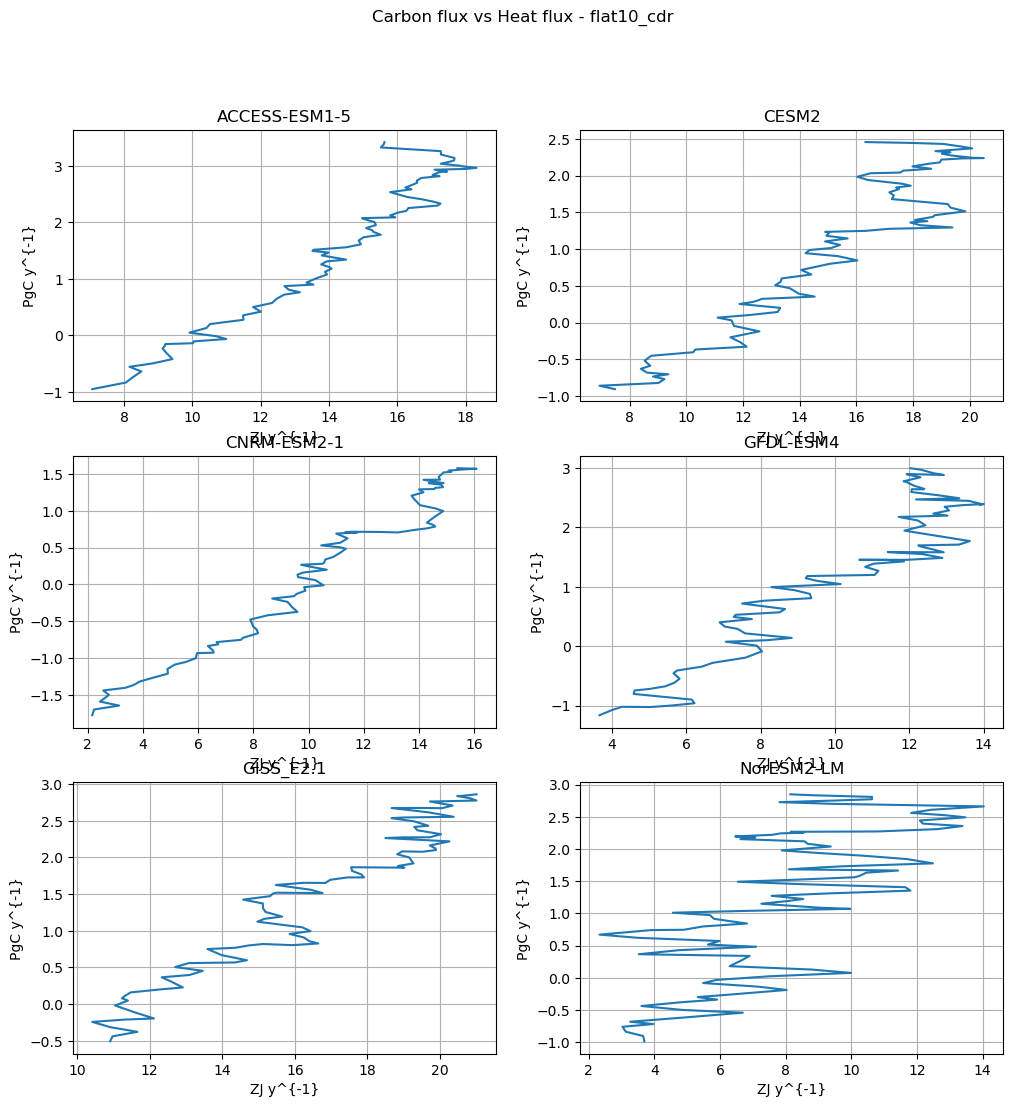

done saving file


In [280]:
run=runlist[2]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # unit conversions


    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr

    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(heatflux, carbonflux)#,'.')
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    plt.xlabel('ZJ y^{-1}')
    plt.ylabel('PgC y^{-1}')


fig.suptitle('Carbon flux vs Heat flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonVsheat_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

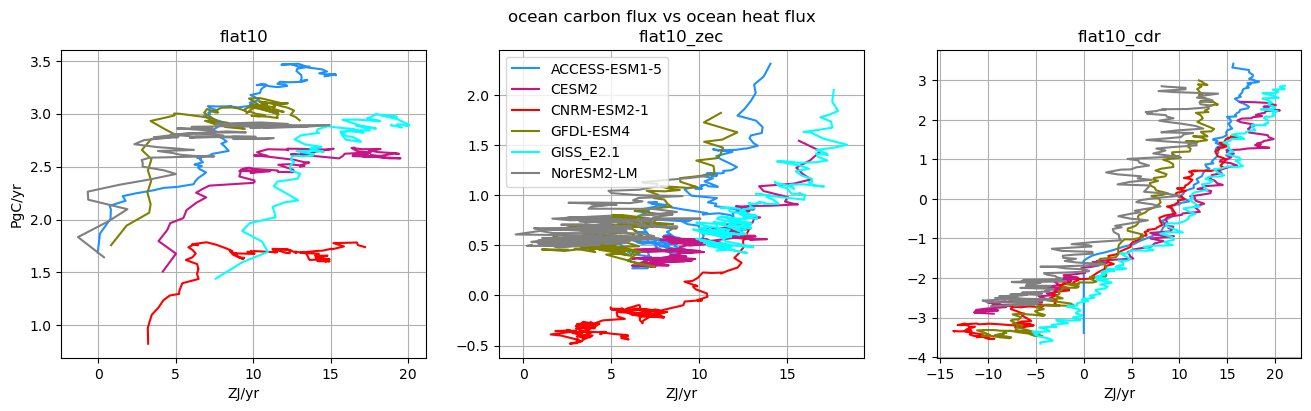

done saving file


In [282]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,4))

r=0
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr

    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    plt.plot(heatflux, carbonflux,color=modelcolors[m])

plt.title(run)
plt.grid()

#plt.ylim([-0.006,0.010])
plt.xlabel('ZJ/yr')
plt.ylabel('PgC/yr')




r=1
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    plt.plot(heatflux, carbonflux,color=modelcolors[m])

    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
plt.xlabel('ZJ/yr')
#plt.ylabel('ZJ K^{-1}')

plt.legend(modellist)

r=2
run=runlist[r]
ax=plt.subplot(1,3,1+r)
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    plt.plot(heatflux, carbonflux,color=modelcolors[m])
    
plt.title(run)
plt.grid()

    #plt.ylim([-0.006,0.010])
plt.xlabel('ZJ/yr')
#plt.ylabel('ZJ K^{-1}')


fig.suptitle('ocean carbon flux vs ocean heat flux')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonVsheat_onepanel_allruns.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

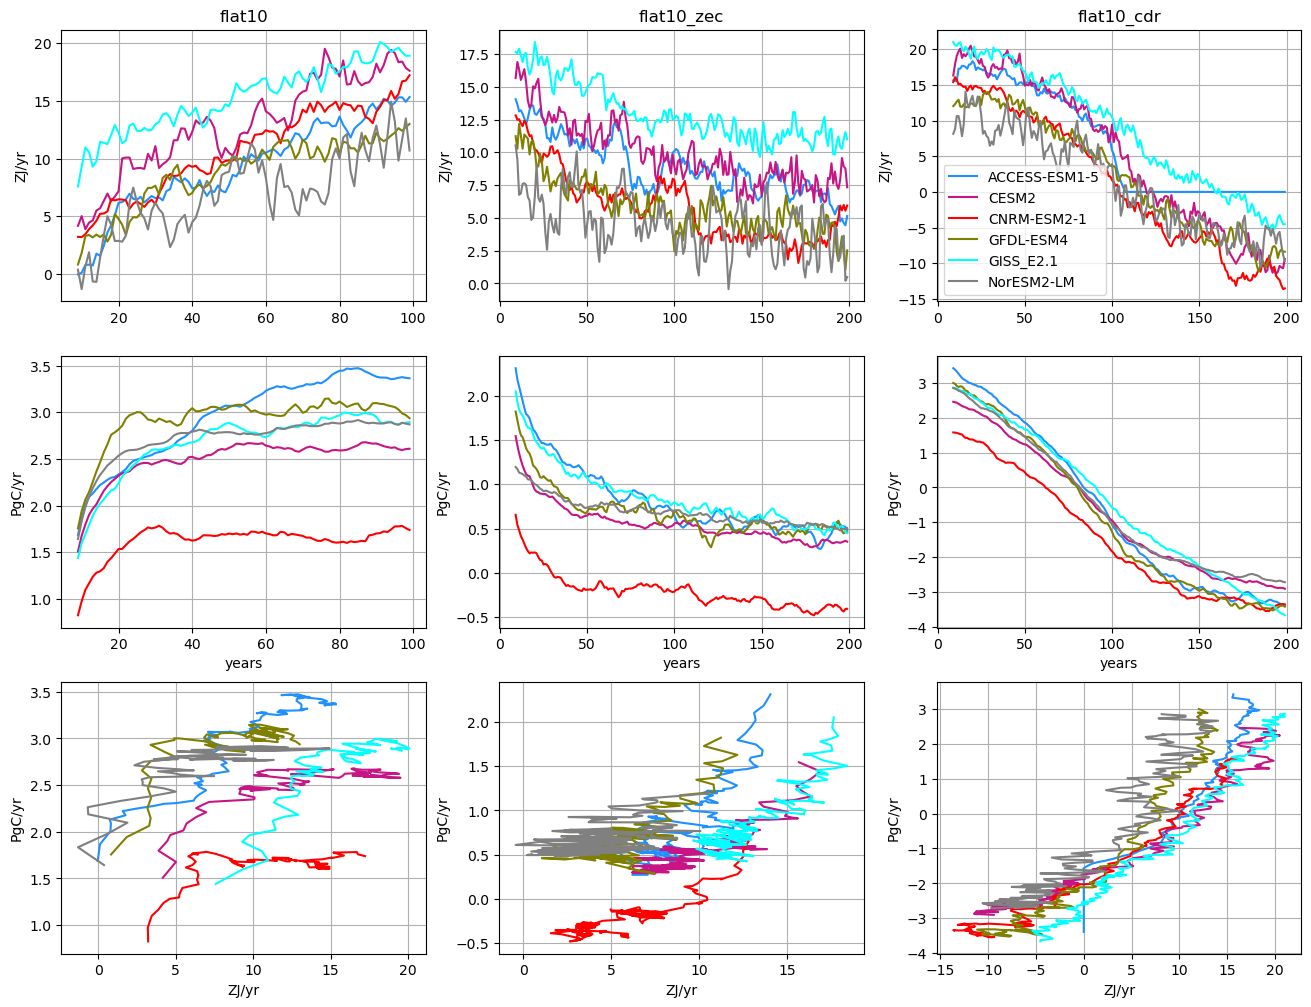

done saving file


In [316]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,12))

r=0
run=runlist[r]

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr

    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    ax=plt.subplot(3,3,1+r)
    plt.plot(heatflux,color=modelcolors[m])
    plt.title(run)
    plt.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ZJ/yr')

    ax=plt.subplot(3,3,1+r+3)
    plt.plot(carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('PgC/yr')
    
    ax=plt.subplot(3,3,1+r+6)
    plt.plot(heatflux, carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ZJ/yr')
    plt.ylabel('PgC/yr')
    



r=1
run=runlist[r]
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    ax=plt.subplot(3,3,1+r)
    plt.plot(heatflux,color=modelcolors[m])
    plt.title(run)
    plt.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ZJ/yr')

    ax=plt.subplot(3,3,1+r+3)
    plt.plot(carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('PgC/yr')
    
    ax=plt.subplot(3,3,1+r+6)
    plt.plot(heatflux, carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ZJ/yr')
    plt.ylabel('PgC/yr')
    

    

r=2
run=runlist[r]
for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    if model=='GISS_E2.1':
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
      
    else:
        # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
        carbonflux=(ds.fgco2[0:200]*speryr*1e-12 * oceanarea[m]).rolling(time=10).mean()
        # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
        heatflux = (ds.hfds[0:200]*speryr*1e-21*oceanarea[m]).rolling(time=10).mean()

    ax=plt.subplot(3,3,1+r)
    plt.plot(heatflux,color=modelcolors[m])
    plt.title(run)
    plt.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ZJ/yr')
    plt.legend(modellist)

    ax=plt.subplot(3,3,1+r+3)
    plt.plot(carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('PgC/yr')
    
    ax=plt.subplot(3,3,1+r+6)
    plt.plot(heatflux, carbonflux,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ZJ/yr')
    plt.ylabel('PgC/yr')
    



#fig.suptitle('ocean carbon flux vs ocean heat flux')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonAndheat_allmodels_allruns.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

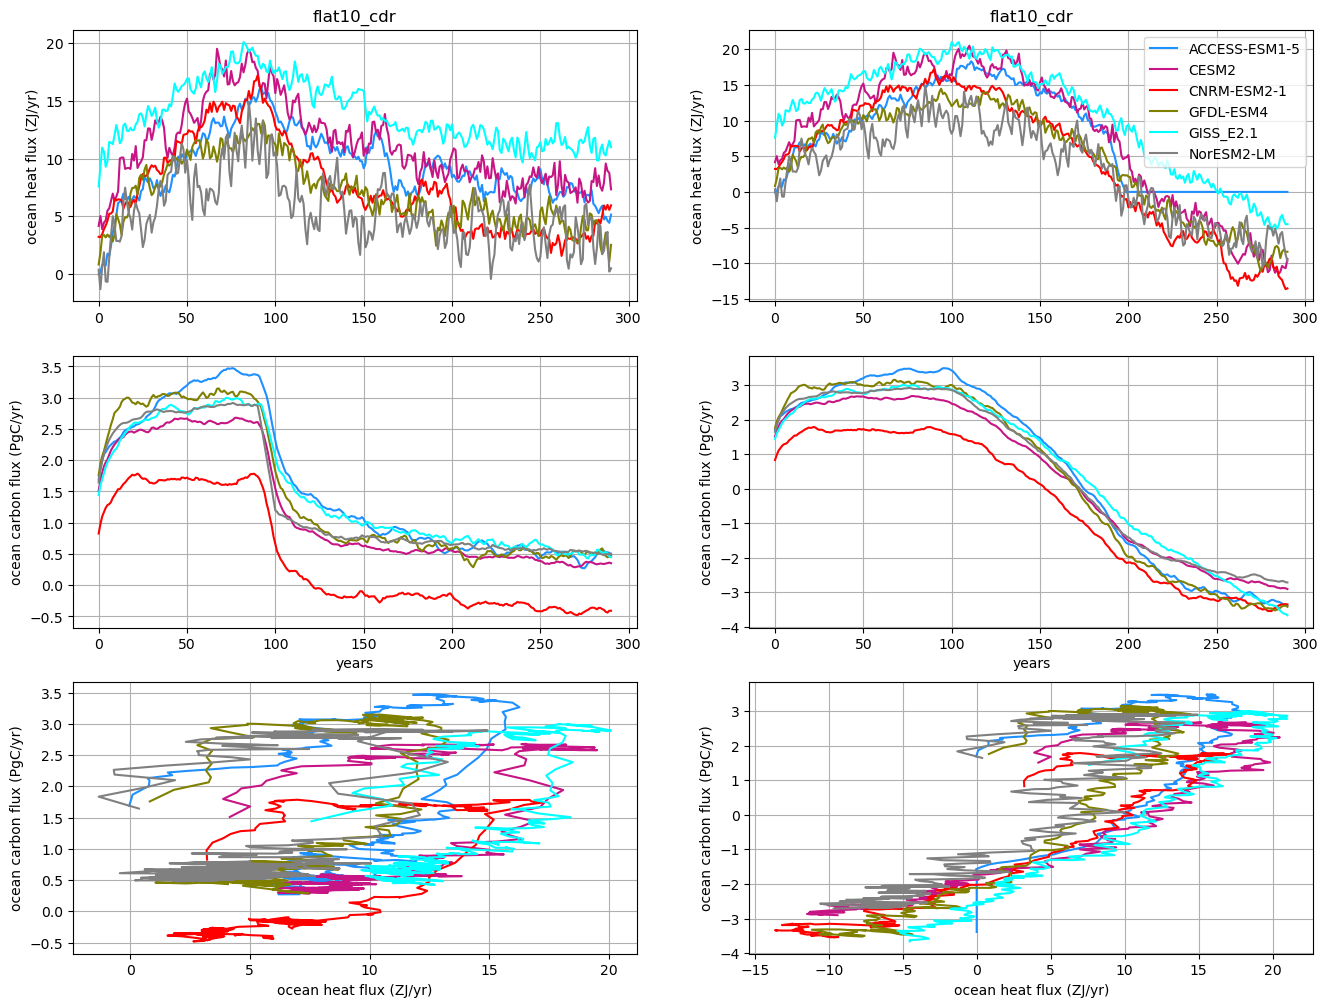

done saving file


In [325]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +runlist[0] +'_timeseries'
    ds0=data_dict[modelkey]

    modelkey=model +'_' +runlist[1] +'_timeseries'
    ds1=data_dict[modelkey]

    modelkey=model +'_' +runlist[2] +'_timeseries'
    ds2=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr


    # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
    #carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    #heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
    # np.convolve(x, np.ones(N)/N, mode='valid')
    
    
    #-- first flat10+flat10zec---
    # concatenate the experiments together
    flat10=np.concatenate((ds0.fgco2[0:100].values, ds1.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion
    flat10zec_carbon_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    
    flat10=np.concatenate((ds0.hfds[0:100].values, ds1.hfds[0:200].values))*speryr*1e-21 * oceanarea[m] #includes unit conversion
    flat10zec_heat_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

    #-- then flat10+flat10cdr---
    flat10=np.concatenate((ds0.fgco2[0:100].values, ds2.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion
    flat10cdr_carbon_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    
    flat10=np.concatenate((ds0.hfds[0:100].values, ds2.hfds[0:200].values))*speryr*1e-21 * oceanarea[m] #includes unit conversion
    flat10cdr_heat_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

    

    ax=plt.subplot(3,2,1)
    plt.plot(flat10zec_heat_smooth,color=modelcolors[m])
    plt.title(run)
    ax.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ocean heat flux (ZJ/yr)')

    ax=plt.subplot(3,2,2)
    plt.plot(flat10cdr_heat_smooth,color=modelcolors[m])
    plt.title(run)
    plt.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ocean heat flux (ZJ/yr)')
    plt.legend(modellist)

    ax=plt.subplot(3,2,3)
    plt.plot(flat10zec_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('ocean carbon flux (PgC/yr)')

    ax=plt.subplot(3,2,4)
    plt.plot(flat10cdr_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('ocean carbon flux (PgC/yr)')
    
    ax=plt.subplot(3,2,5)
    plt.plot(flat10zec_heat_smooth, flat10zec_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ocean heat flux (ZJ/yr)')
    plt.ylabel('ocean carbon flux (PgC/yr)')

    ax=plt.subplot(3,2,6)
    plt.plot(flat10cdr_heat_smooth, flat10cdr_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ocean heat flux (ZJ/yr)')
    plt.ylabel('ocean carbon flux (PgC/yr)')




#fig.suptitle('ocean carbon flux vs ocean heat flux')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonAndheat_allmodels_combinedts.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

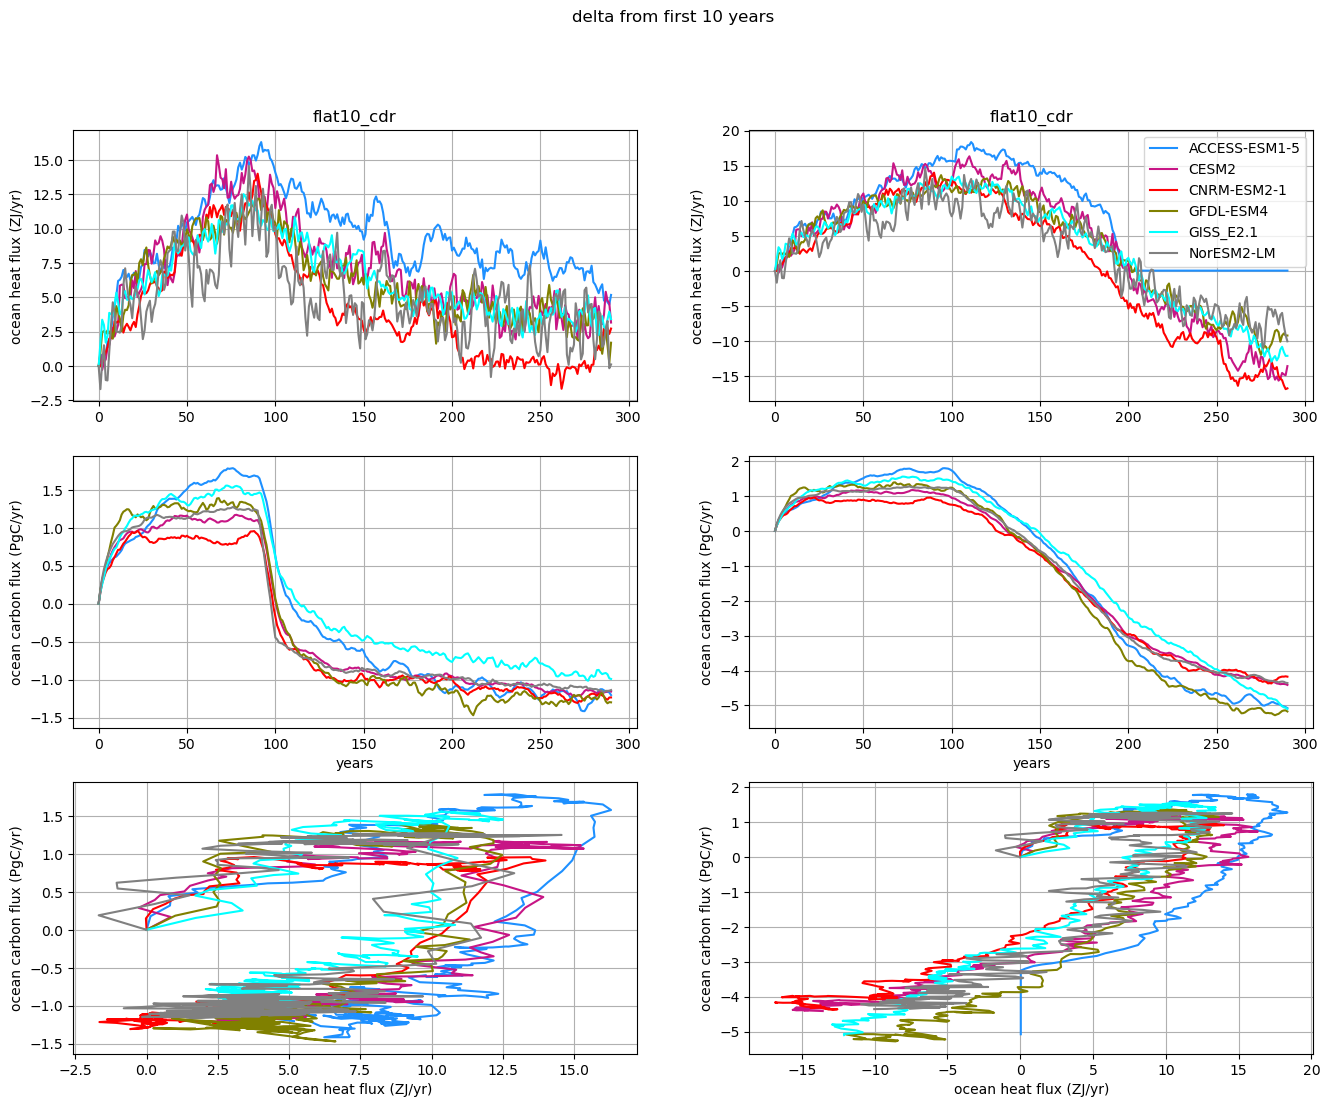

done saving file


In [326]:
#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(16,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +runlist[0] +'_timeseries'
    ds0=data_dict[modelkey]

    modelkey=model +'_' +runlist[1] +'_timeseries'
    ds1=data_dict[modelkey]

    modelkey=model +'_' +runlist[2] +'_timeseries'
    ds2=data_dict[modelkey]

    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr


    # fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
    #carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    #heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
    # np.convolve(x, np.ones(N)/N, mode='valid')
    
    
    #-- first flat10+flat10zec---
    # concatenate the experiments together
    flat10=np.concatenate((ds0.fgco2[0:100].values, ds1.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion
    smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    flat10zec_carbon_smooth = smooth-smooth[0]
    
    flat10=np.concatenate((ds0.hfds[0:100].values, ds1.hfds[0:200].values))*speryr*1e-21 * oceanarea[m] #includes unit conversion
    smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    flat10zec_heat_smooth = smooth-smooth[0]

    #-- then flat10+flat10cdr---
    flat10=np.concatenate((ds0.fgco2[0:100].values, ds2.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion
    smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    flat10cdr_carbon_smooth = smooth-smooth[0]
    
    flat10=np.concatenate((ds0.hfds[0:100].values, ds2.hfds[0:200].values))*speryr*1e-21 * oceanarea[m] #includes unit conversion
    smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')
    flat10cdr_heat_smooth = smooth-smooth[0]

    

    ax=plt.subplot(3,2,1)
    plt.plot(flat10zec_heat_smooth,color=modelcolors[m])
    plt.title(run)
    ax.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ocean heat flux (ZJ/yr)')

    ax=plt.subplot(3,2,2)
    plt.plot(flat10cdr_heat_smooth,color=modelcolors[m])
    plt.title(run)
    plt.grid(True)
    #plt.xlabel('years')
    plt.ylabel('ocean heat flux (ZJ/yr)')
    plt.legend(modellist)

    ax=plt.subplot(3,2,3)
    plt.plot(flat10zec_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('ocean carbon flux (PgC/yr)')

    ax=plt.subplot(3,2,4)
    plt.plot(flat10cdr_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('years')
    plt.ylabel('ocean carbon flux (PgC/yr)')
    
    ax=plt.subplot(3,2,5)
    plt.plot(flat10zec_heat_smooth, flat10zec_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ocean heat flux (ZJ/yr)')
    plt.ylabel('ocean carbon flux (PgC/yr)')

    ax=plt.subplot(3,2,6)
    plt.plot(flat10cdr_heat_smooth, flat10cdr_carbon_smooth,color=modelcolors[m])
    #plt.title(run)
    plt.grid(True)
    plt.xlabel('ocean heat flux (ZJ/yr)')
    plt.ylabel('ocean carbon flux (PgC/yr)')




fig.suptitle('delta from first 10 years')
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'carbonAndheat_allmodels_combinedts_delta.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

In [ ]:

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    run=runlist[0]
    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]
    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    carbonflux = ds.fgco2[0:100]*speryr*1e-12*oceanarea[m]
    heatflux = ds.hfds[0:100]*speryr*1e-21*oceanarea[m]

    run=runlist[1]
    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]
    # W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
    carbonflux = ds.fgco2[0:200]*speryr*1e-12*oceanarea[m]
    heatflux = ds.hfds[0:200]*speryr*1e-21*oceanarea[m]



    
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()

    
    if model=='GISS_E2.1':
        ts2=ts[0:200].rolling(year=10).mean()
    else:
        ts2=ts[0:200].rolling(time=10).mean()

    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts2)
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('PgC/yr')


fig.suptitle('ocean carbon flux - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceancarbonflux_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

# Scratch code

In [305]:
m=0
model=modellist[m]

modelkey=model +'_' +runlist[0] +'_timeseries'
ds0=data_dict[modelkey]

modelkey=model +'_' +runlist[1] +'_timeseries'
ds1=data_dict[modelkey]

modelkey=model +'_' +runlist[2] +'_timeseries'
ds2=data_dict[modelkey]

# W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr


# fgco2 is in kgC m-2 s-1 => *speryr * Pg/kg * m2 of ocean = PgC/yr
#carbonflux=(ds.fgco2[0:100]*speryr*1e-12 * oceanarea[m]).rolling(year=10).mean()
# W/m2 = J/m2/s => *speryr * ZJ/J * m2 of ocean = ZJ/yr
#heatflux = (ds.hfds[0:100]*speryr*1e-21*oceanarea[m]).rolling(year=10).mean()
# np.convolve(x, np.ones(N)/N, mode='valid')


#-- first flat10+flat10zec---
# concatenate the experiments together
flat10=np.concatenate((ds0.fgco2[0:100].values, ds1.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion

In [319]:
flat10=np.concatenate((ds0.fgco2[0:100].values, ds1.fgco2[0:200].values))*speryr*1e-12 * oceanarea[m] #includes unit conversion
flat10zec_carbon_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

flat10zec_carbon_smooth

array([1.64358403, 1.83428413, 1.98285642, 2.09771355, 2.18742013,
       2.26352238, 2.32944223, 2.37885604, 2.43026226, 2.4642303 ,
       2.49978386, 2.53492354, 2.56241666, 2.5842351 , 2.59431898,
       2.59674905, 2.6005389 , 2.61243751, 2.62770092, 2.64721388,
       2.65432015, 2.65807206, 2.6627688 , 2.66897737, 2.68379091,
       2.71163305, 2.75066095, 2.77044684, 2.77831499, 2.7776127 ,
       2.77663062, 2.79243113, 2.80148048, 2.81363457, 2.80492888,
       2.79364429, 2.77940427, 2.77160479, 2.78295541, 2.78385667,
       2.78738702, 2.78689493, 2.78304824, 2.77093491, 2.76408218,
       2.77617864, 2.76682005, 2.76981474, 2.76098423, 2.76083058,
       2.77102028, 2.77643025, 2.78486957, 2.80316832, 2.83259896,
       2.82363769, 2.82127789, 2.83244565, 2.84261722, 2.85724962,
       2.86084296, 2.85944491, 2.86123645, 2.85166391, 2.85158678,
       2.85151072, 2.85970815, 2.87649697, 2.87810771, 2.8887069 ,
       2.88359902, 2.87991589, 2.88578495, 2.90085867, 2.89879

In [ ]:
flat10zec_carbon_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

flat10=[ds0.hfds[0:100].values, ds1.hfds[0:200].values]*speryr*1e-21 * oceanarea[m] #includes unit conversion
flat10zec_heat_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

#-- then flat10+flat10cdr---
flat10=[ds0.fgco2[0:100].values, ds2.fgco2[0:200].values]*speryr*1e-12 * oceanarea[m] #includes unit conversion
flat10cdr_carbon_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

flat10=[ds0.hfds[0:100].values, ds2.hfds[0:200].values]*speryr*1e-21 * oceanarea[m] #includes unit conversion
flat10cdr_heat_smooth=np.convolve(flat10, np.ones(10)/10, mode='valid')

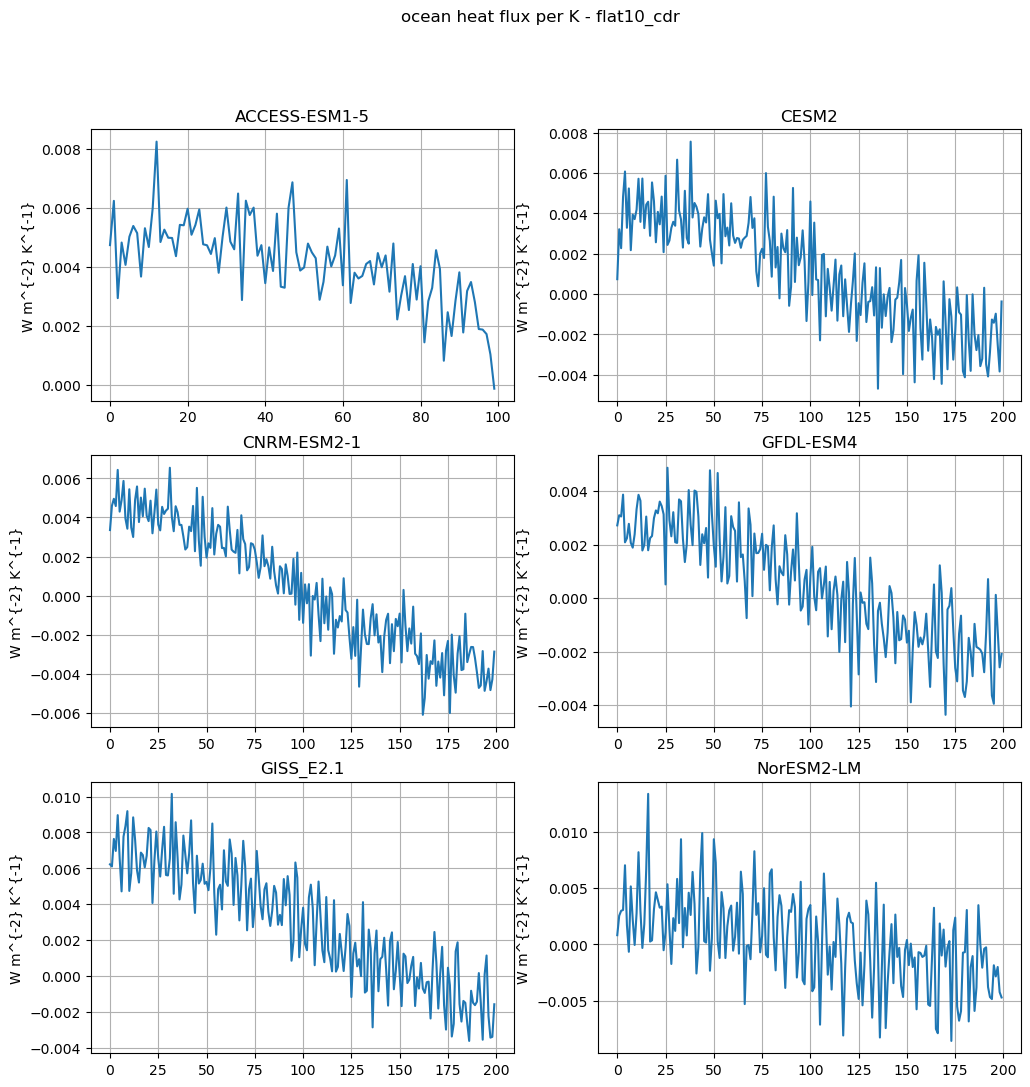

done saving file


In [193]:
run=runlist[2]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

for m in range(len(modellist)):
    model=modellist[m]

    modelkey=model +'_' +run +'_timeseries'
    ds=data_dict[modelkey]
    ts = ds.hfds/ds.tas
    
    ax=plt.subplot(3,2,m+1)
    plt.plot(ts[0:200])
    plt.title(model)
    plt.grid()

    #plt.ylim([-0.006,0.010])
    #plt.xlabel('year')
    plt.ylabel('W m^{-2} K^{-1}')


fig.suptitle('ocean heat flux per K - ' +run)
# show the plot:
plt.show()


# save the plot
fig.savefig('figures/' 'oceanheatfluxpertemp_'+run +'.png', bbox_inches='tight', dpi=1200)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()

Text(0.5, 1.0, 'NorESM2-LM')

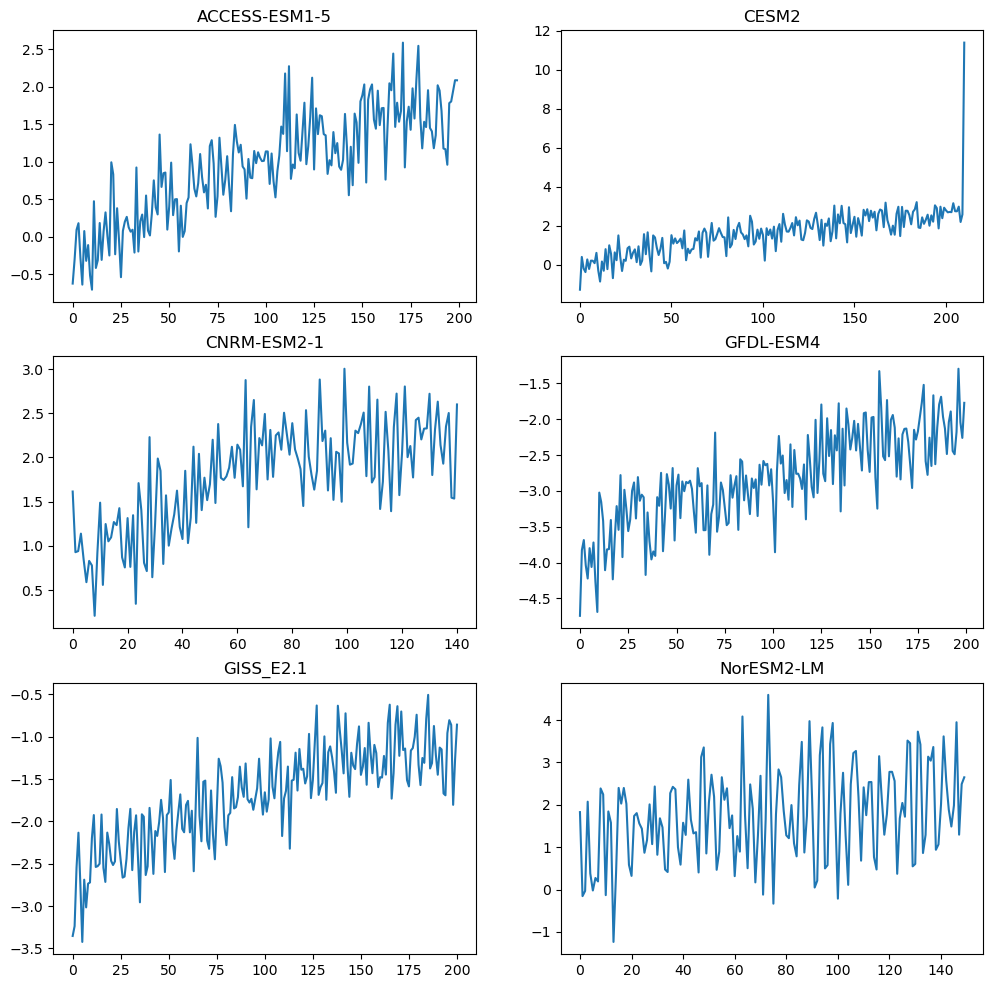

In [40]:
run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))


m=0
model=modellist[m]
modelkey=model +'_' +run 
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['i','j']).groupby('time.year').mean('time')

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)

m=1
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['nlat','nlon']).groupby('time.year').mean('time')

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)

m=2
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['x','y']).groupby('time.year').mean('time')

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)

m=3
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['xh','yh']).groupby('time.year').mean('time') 

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)

m=4
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['lat','lon'])#.groupby('time.year').mean('time') # GISS already annual mean

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)

m=5
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ts=ds.hfds.mean(dim=['i','j']).groupby('time.year').mean('time')

ax=plt.subplot(3,2,m+1)
plt.plot(ts)
plt.title(model)


In [47]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

data_dictC={}

# loop over models
for m in range(1):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xc.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
            if 'nep' in dsmerge_f:
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep')
                
            # check units and convert if necessary - at the moment this is just CESM for carbon variables
            #if ds[veg].units != unitslist[v]:
                # the unit does not match what we expect, 
                # convert the unit and update the metadata
            # At the moment this only applies to CESM, but should catch the CESM units and not others
            # flux variables
            # test first to see if the variable exists. nbp is missnamed in one model
            if var in dsmerge_f: 
                if dsmerge_f[var].units == 'gC/m^2/s':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                # stock variables
                elif dsmerge_f[var].units == 'gC/m^2':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2'
                    
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xc.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                else:
                    nan_dataarray = xc.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray


            
            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
                
                
        
        # save output to a dictionary
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dictC[model +'_' +runlist[r]] = dsmerge_v


2024-07-03 16:30:17,320 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:30:17,320 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:30:50,042 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:30:50,042 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.


adding ACCESS-ESM1-5 flat10 to dict


2024-07-03 16:31:08,449 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:31:08,449 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:31:25,339 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:31:25,339 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:32:26,468 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:32:26,468 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:32:42,090 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16

adding ACCESS-ESM1-5 flat10_zec to dict


2024-07-03 16:33:36,608 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:33:36,608 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:33:50,157 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.
2024-07-03 16:33:50,157 [WARNING]: bounds.py(add_missing_bounds:188) >> The j coord variable has a 'units' attribute that is not in degrees.


adding ACCESS-ESM1-5 flat10_cdr to dict


In [85]:
run=runlist[0]
m=0
model=modellist[m]
modelkey=model +'_' +run
ds=data_dictC[modelkey]
ds_area=data_dict[model +'_areacello']



area_weighted_ann_mean1=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
#data_dict[model +'_' +runlist[r] +'_hfds_ts'] = area_weighted_ann_mean
ds1 = area_weighted_ann_mean1.to_dataset(name='hfds')

area_weighted_ann_mean2=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['i','j'])/ds_area.areacello.sum(dim=['i','j'])
#data_dict[model +'_' +runlist[r] +'_fgco2_ts'] = area_weighted_ann_mean
ds2 = area_weighted_ann_mean1.to_dataset(name='fgco2')

ds3=xr.merge([ds1,ds2])
ds3

<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.


<xarray.Dataset>
Dimensions:  (time: 200)
Coordinates:
  * time     (time) object 0101-01-01 00:00:00 ... 0300-01-01 00:00:00
Data variables:
    hfds     (time) float64 -0.03204 -0.02473 0.303 0.2543 ... 2.041 2.205 2.312
    fgco2    (time) float64 -0.03204 -0.02473 0.303 0.2543 ... 2.041 2.205 2.312

In [106]:

m=1

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']
ds_areaA=data_dict[model +'_areacella']

area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
ts1 = area_weighted_ann_mean.to_dataset(name='hfds')

area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')

area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
ts3 = area_weighted_ann_mean.to_dataset(name='tas')

data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])


<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.
<string>:6: FutureWarning: 'AS' is deprecated and will be removed in a future version. Please use 'YS' instead of 'AS'.


In [105]:
arg=ds_area.areacello.sum()
arg


<xarray.DataArray 'areacello' ()>
array(5.04921015e+18)

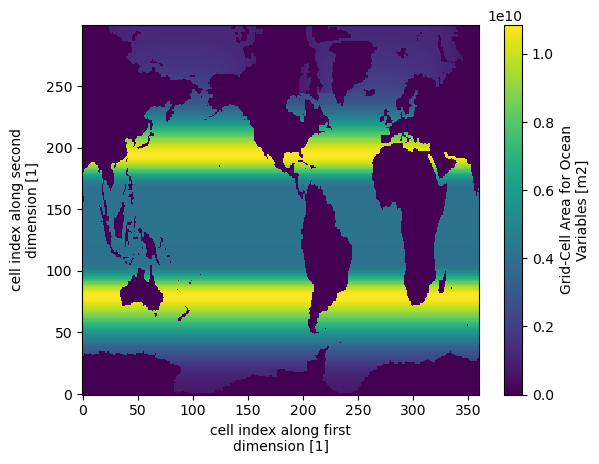

In [58]:
ds_area.areacello.plot()

In [41]:
run=runlist[0]
m=0
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']

#ds_area

# make lat lon weights and take a weighted spatial mean
weights = np.cos(np.deg2rad(air.lat))
air_weighted = air.weighted(weights)
weighted_mean = air_weighted.mean(("lon", "lat"))

#ts=ds.hfds.mean(dim=['i','j']).groupby('time.year').mean('time') # need to add proper weighting for months and gridcells



<xarray.Dataset>
Dimensions:             (j: 300, i: 360, vertices: 4)
Coordinates:
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
Dimensions without coordinates: vertices
Data variables:
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    areacello           (j, i) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP CDRMIP
    branch_method:          standard
    branch_time_in_child:   42002.0
    branch_time_in_parent:  42002.0
    contact:                access_csiro@csiro.au
    ...                     ...
    tracking_id:            hdl:21.14100/e351aef7-88e4-47ec-960a-c7a090d852b6
    variable_id:            areacello
    variant_label:          r1i1p1f2
    version:                v20231220
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0

In [90]:
m=4 # GISS already in annual mean

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']
ds_areaA=data_dict[model +'_areacella']

area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['lat','lon'])/ds_area.areacello.sum(dim=['lat','lon'])


KeyError: 'GISS_E2.1_areacello'

ValueError: x and y can be no greater than 2D, but have shapes (2400,) and (2400, 300, 360)

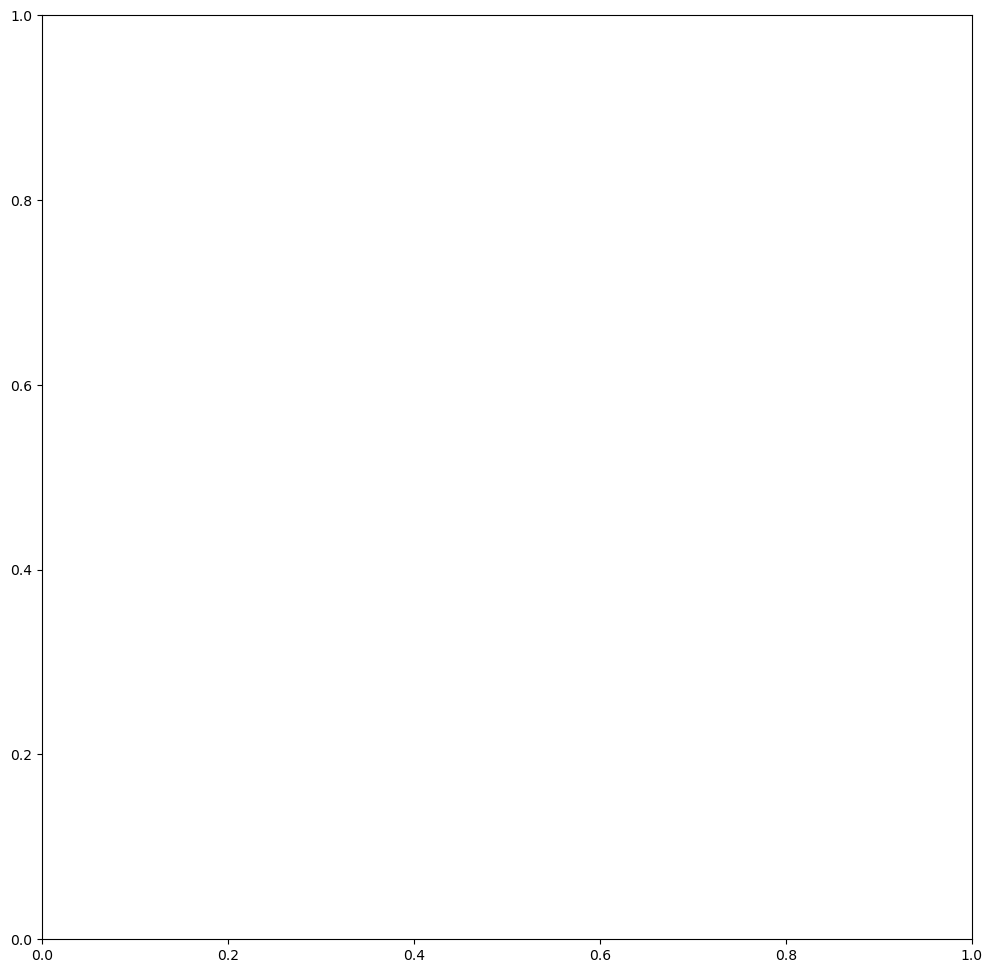

In [16]:
#ds=data_dict['ACCESS-ESM1-5_flat10']
#plt.plot(ds.hfds.mean(dim=['i','j']).rolling(time=12).mean())

run=runlist[0]

#def plot_all_models_one_var(var, run, modellist, modellist_safe):
fig = plt.figure(figsize=(12,12))

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    ax=plt.subplot(3,2,m+1)
    
    # create datasets for each model + experiment combination + variable
    ds=data_dict[model +'_' +run]
    #plt.plot(ds.hfds.mean(dim=['lat','lon']).rolling(time=12).mean())
    plt.plot(ds.hfds.rolling(time=12).mean())

    plt.title(model)

fig.suptitle(run)
# show the plot:

plt.show()

In [15]:
ds=data_dict['GFDL-ESM4_flat10']
plt.plot(ds.hfds.mean(dim=['xh','yh']).rolling(time=12).mean())


<xarray.Dataset>
Dimensions:     (time: 2400, yh: 576, xh: 720, nv: 2, bnds: 2, lat: 180,
                 lon: 288)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0001-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * bnds        (bnds) float64 1.0 2.0
    height      float64 2.0
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    average_DT  (time) timedelta64[ns] 31 days 28 days ... 30 days 31 days
    average_T1  (time) object 0001-01-01 00:00:00 ... 0200-10-12 00:00:00
    average_T2  (time) object 0001-02-01 00:00:00 ... 0200-11-12 00:00:00
    fgco2       (time, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan
    time_bnds   (time, nv) object 0001-01-01 00:00:00 ... 0201-01-01 00:00:00
    hfds        (time, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan
    lat_bnds    (time, lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds    (time, lon, bnds) float64 0.0 1.25 1.25 ... 358.8 358.8 360.0
    tas         (time, lat, lon) float32 239.7 239.7 239.6 ... 254.0 254.0 254.0
Attributes: (12/22)
    associated_files:       areacello: 00010101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    history:                NOAA GFDL GFDL-ESM4 model output prepared for emi...
    source_id:              GFDL-ESM4
    ...                     ...
    parent_experiment_id:   esm-piControl
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-ESM4
    parent_variant_label:   r1i1p1f1
    references:             Dunne et al. (2020). The GFDL Earth System Model ...
    license:                Model data produced by NOAA-GFDL is licensed unde...

In [36]:
m=5
model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds
#ts=ds.hfds.mean(dim=['i','j']).groupby('time.year').mean('time')

#plt.plot(ts)

IndexError: list index out of range

In [129]:
m=1

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]
ds_area=data_dict[model +'_areacello']
ds_areaA=data_dict[model +'_areacella']

area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'hfds')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
ts1 = area_weighted_ann_mean.to_dataset(name='hfds')

area_weighted_ann_mean=(ds_area.areacello*weighted_temporal_mean(ds,'fgco2')).sum(dim=['nlat','nlon'])/ds_area.areacello.sum()
ts2 = area_weighted_ann_mean.to_dataset(name='fgco2')

areaA = ds_areaA.areacella.squeeze(dim='time', drop=True)
area_weighted_ann_mean=(areaA*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/areaA.sum(dim=['lat','lon'])
ts3 = area_weighted_ann_mean.to_dataset(name='tas')

# save output to a dictionary
print('adding ' +model +' ' +runlist[r] +'_timeseries to dict')
data_dict[model +'_' +runlist[r] +'_timeseries'] = xr.merge([ts1,ts2,ts3])


adding CESM2 flat10_timeseries to dict


In [120]:
m=1

model=modellist[m]
modelkey=model +'_' +run
ds=data_dict[modelkey]



area_weighted_ann_mean=(ds_areaA.areacella*weighted_temporal_mean(ds,'tas')).sum(dim=['lat','lon'])/ds_areaA.areacella.sum(dim=['lat','lon'])
#area_weighted_ann_mean
#ts3 = area_weighted_ann_mean.to_dataset(name='tas')

#ts3

<xarray.Dataset>
Dimensions:     (time: 2520, d2: 2, nlat: 384, nlon: 320, lat: 192, lon: 288,
                 nbnd: 2)
Coordinates:
  * time        (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
    TLONG       (nlat, nlon) float64 ...
    TLAT        (nlat, nlon) float64 ...
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: d2, nlat, nlon, nbnd
Data variables:
    time_bound  (time, d2) object ...
    fgco2       (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    hfds        (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    time_bnds   (time, nbnd) object ...
    tas         (time, lat, lon) float32 243.8 243.8 243.8 ... 259.6 259.6 259.6
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 13:34:03 2024: ncrename -v FG_CO2,fgco2 /gl...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [199]:
m=1
model=modellist[m]

modelkey=model +'_' +run# +'_timeseries'
ds=data_dict[modelkey]

ds

<xarray.Dataset>
Dimensions:     (time: 2520, d2: 2, nlat: 384, nlon: 320, lat: 192, lon: 288,
                 nbnd: 2)
Coordinates:
  * time        (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
    TLONG       (nlat, nlon) float64 ...
    TLAT        (nlat, nlon) float64 ...
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: d2, nlat, nlon, nbnd
Data variables:
    time_bound  (time, d2) object ...
    fgco2       (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    hfds        (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    time_bnds   (time, nbnd) object ...
    tas         (time, lat, lon) float32 243.8 243.8 243.8 ... 259.6 259.6 259.6
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 13:34:03 2024: ncrename -v FG_CO2,fgco2 /gl...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [244]:
# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
m=1
model=modellist[m]

# loop over experiments
for r in range(len(runlist)):
    run = runlist_wc[r]

   # loop over variables
    for v in range(len(varlist)):

        
        var=varlist[v]
        searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
        if model =='CESM2':
            # all models have a var_ filename except CESM
            searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
        
        filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim
    
        # loop over filenames. some variables are stored in multiple files
        # this should be possible with xr.open_mfdataset but it isn't loading all of time points
        for f in range(len(filenamelist)):
            file = filenamelist[f]
            if f==0:
                dsmerge_f = xr.open_dataset(file, use_cftime=True)
            else:
                ds = xr.open_dataset(file, use_cftime=True)
                dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')
    
        # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
        if 'nep' in dsmerge_f:
            dsmerge_f['nbp'] = dsmerge_f['nep']
            #dsmerge_f = dsmerge_f.drop_vars('nep')
            
        # check units and convert if necessary - at the moment this is just CESM for carbon variables
        #if ds[veg].units != unitslist[v]:
            # the unit does not match what we expect, 
            # convert the unit and update the metadata
        # At the moment this only applies to CESM, but should catch the CESM units and not others
        # flux variables
        # test first to see if the variable exists. nbp is missnamed in one model
        if var in dsmerge_f: 
            if dsmerge_f[var].units == 'gC/m^2/s':
                dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
            # stock variables
            elif dsmerge_f[var].units == 'gC/m^2':
                dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                dsmerge_f[var].attrs['units'] = 'kg m-2'
            elif dsmerge_f[var].units == 'mmol/m^3 cm/s':
                dsmerge_f[var]=dsmerge_f[var]* 1e-8* 12 # convert from mmol/m^3 cm/s to kgC/m2/s 
                dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                
        else: #var does not exist
            ds=dsmerge_f
            # add a blank variable so that loops work
            if 'time' in ds:
                nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                             coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
            else:
                nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                         coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
    
    
            # Assign the new variable to the dataset
            dsmerge_f[var] = nan_dataarray
    
            
        
        # merge all variables into one dataset
        # if it's the first variable, then start a new datset, otherwise merge with existing
        if v ==0:
            dsmerge_v = dsmerge_f.copy()
        else:
            dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')
    
        # add a new variable that is the sum of all carbon pools
        if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
            dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
            
            
    
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +' to dict')
    data_dict[model +'_' +runlist[r]] = dsmerge_v


adding CESM2 flat10 to dict
adding CESM2 flat10_zec to dict
adding CESM2 flat10_cdr to dict
